In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
pd.options.display.max_columns = 100
import gc
from time import time
import seaborn as sns
import pandas_profiling as pdp
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')
from IPython.display import display

from sklearn.model_selection import KFold,train_test_split
from sklearn.metrics import mean_squared_error

import lightgbm as lgb
from hyperopt import fmin, tpe, hp,Trials,STATUS_OK,space_eval

import japanize_matplotlib
import optuna

In [2]:
train=pd.read_feather('../data/train_feat2.ftr')
test=pd.read_feather('../data/test_feat2.ftr')
Y_train=train.rent
X_train=train.drop(['id','rent'],axis=1)

test.index=test['index']
X_test=test.drop(['id','rent','index'],axis=1)

In [20]:
train.select_dtypes(exclude='category').columns[60:]

Index(['ペアガラス', 'ルーフバルコニー', 'ロフト付き', '下水', '二世帯住宅', '二重サッシ', '井戸', '公営水道',
       '冷房', '出窓', '地下室', '室内洗濯機置場', '室外洗濯機置場', '専用庭', '床下収納', '床暖房', '排水その他',
       '敷地内ごみ置き場', '水道その他', '汲み取り', '洗濯機置場なし', '浄化槽', '石油暖房', '都市ガス', '防音室',
       'parking_price', 'convenience_count', 'supermarket_count', '大学', '郵便局',
       'コインパーキング', 'ドラッグストア', '銀行', 'スーパー', '小学校', 'デパート', '病院', 'コンビニ',
       '幼稚園・保育園', '総合病院', '図書館', '学校', 'クリーニング', '月極駐車場', '公園', 'レンタルビデオ',
       '飲食店', 'is_rent', 'period_num', 'longitude', 'latitude',
       'station_access', 'access_1_distance', 'access_2_distance',
       'access_3_distance', 'access_4_distance', 'rent/S_mean', 'rent/S_max',
       'rent/S_min', 'rent/S_median', 'rent/S_std', 'rent_mean', 'rent_max',
       'rent_min', 'rent_median', 'rent_std'],
      dtype='object')

In [22]:
cols=['rent', 'old_num', 'square_num', 'room_floor', 'building_floor',
       'underground','parking_price', 'convenience_count', 'supermarket_count','period_num', 'longitude', 'latitude',
       'station_access', 'access_1_distance', 'access_2_distance',
       'access_3_distance', 'access_4_distance', 'rent/S_mean', 'rent/S_max',
       'rent/S_min', 'rent/S_median', 'rent/S_std', 'rent_mean', 'rent_max',
'rent_min', 'rent_median', 'rent_std']

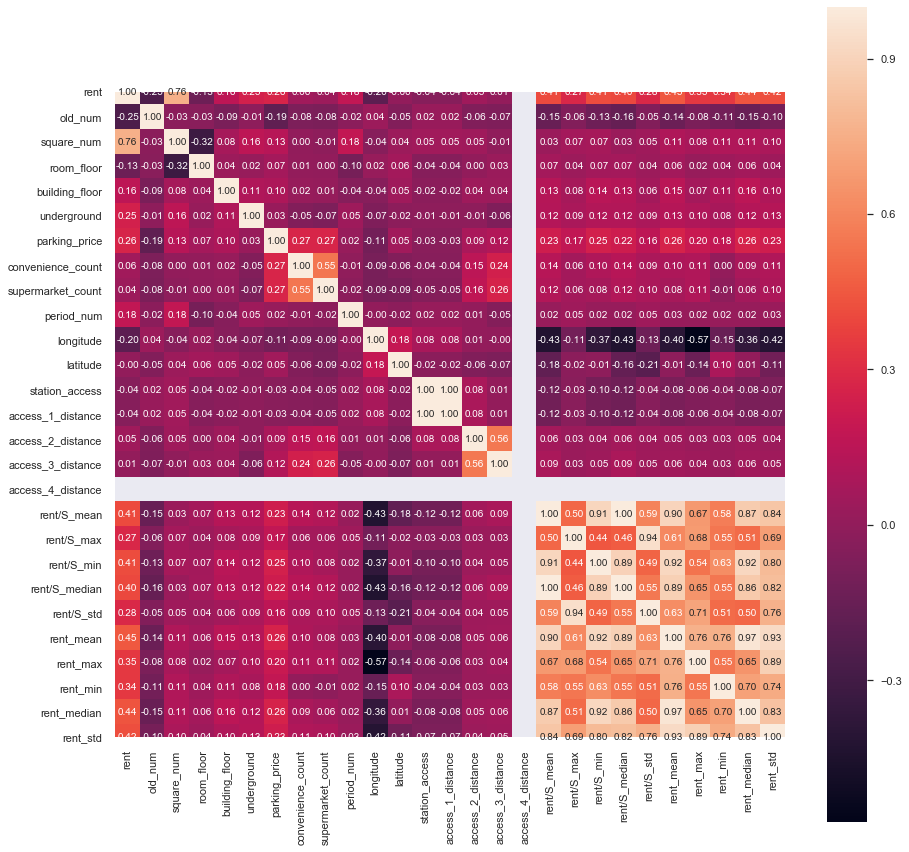

In [30]:
plt.figure(figsize=(15,15))
cm=np.corrcoef(train[cols].values.T)
sns.set(font_scale=1.)
hm=sns.heatmap(cm,cbar=True,annot=True,square=True,fmt='.2f',annot_kws={'size':10},yticklabels=cols,xticklabels=cols)
plt.show()

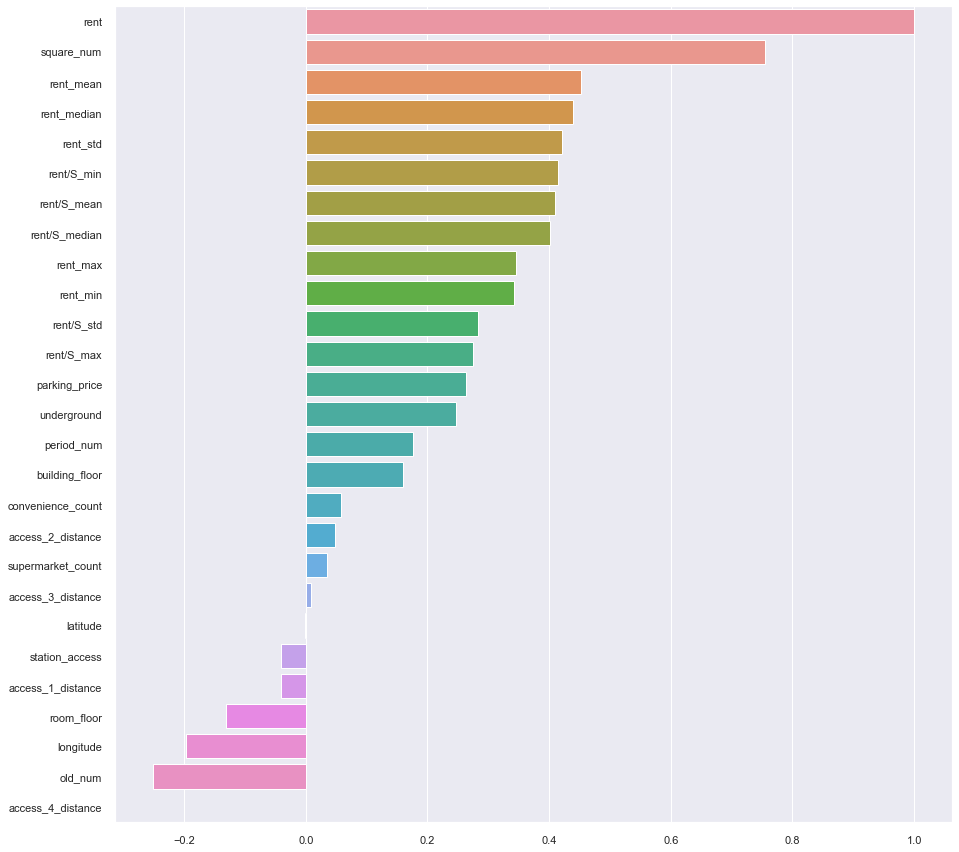

In [50]:
df=pd.DataFrame(cm,columns=cols,index=cols).sort_values(by='rent',ascending=False)['rent']
plt.figure(figsize=(15,15))
sns.barplot(df.values,df.index)

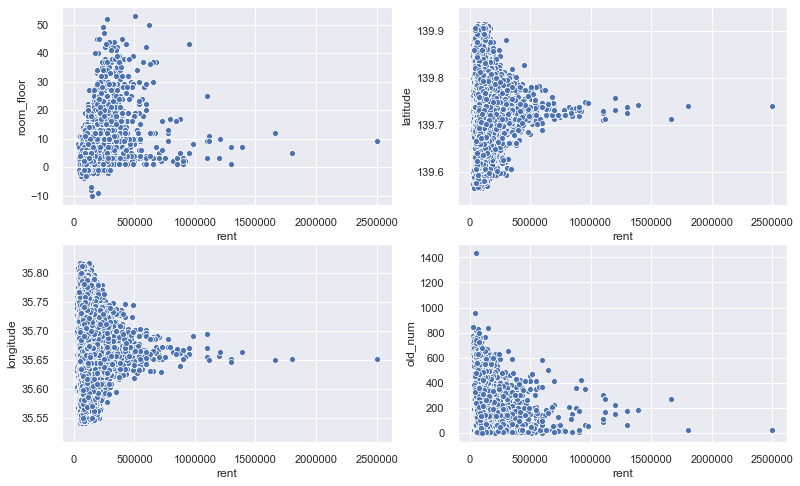

In [71]:
fig,ax=plt.subplots(2,2,figsize=(13,8))
sns.scatterplot(y='room_floor',x='rent',data=train[train['room_floor']!=-999],ax=ax[0][0])
sns.scatterplot(y='latitude',x='rent',data=train[train['room_floor']!=-999],ax=ax[0][1])
sns.scatterplot(y='longitude',x='rent',data=train[train['room_floor']!=-999],ax=ax[1][0])

sns.scatterplot(y='old_num',x='rent',data=train[train['room_floor']!=-999],ax=ax[1][1])

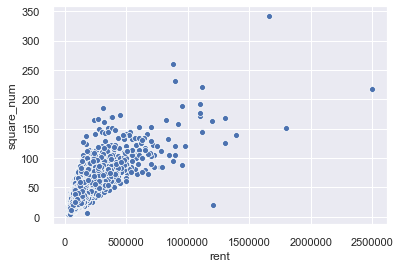

In [73]:
sns.scatterplot(y='square_num',x='rent',data=train[train['room_floor']!=-999])
plt.show()

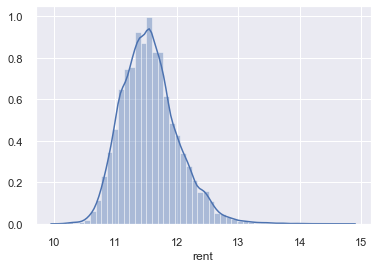

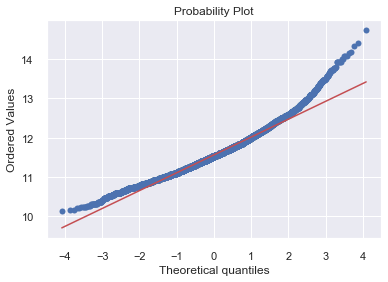

In [87]:
sns.distplot(np.log(train['rent']))
plt.show()
from scipy import stats
res = stats.probplot(np.log(train['rent']), plot=plt)
plt.show()

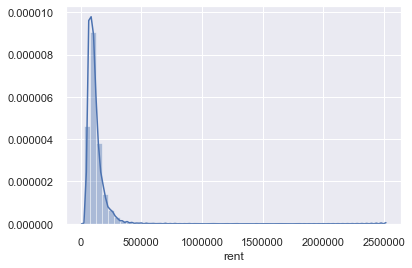

In [76]:
sns.distplot(train['rent'])

In [79]:
np.exp(np.log(train['rent']))

0         75000.0
1         76000.0
2        110000.0
3        150000.0
4         74000.0
           ...   
31462     80000.0
31463     54500.0
31464    125000.0
31465     98000.0
31466     81000.0
Name: rent, Length: 31467, dtype: float64

In [80]:
train['rent']

0         75000.0
1         76000.0
2        110000.0
3        150000.0
4         74000.0
           ...   
31462     80000.0
31463     54500.0
31464    125000.0
31465     98000.0
31466     81000.0
Name: rent, Length: 31467, dtype: float64